# Australian Open AO to AI competition

Hello world! This is the first post of <b>Grist for the Mills</b>, a machine learning blog about interesting problems and data that I’ve encountered and my thought process on solving those problems. I would love any feedback about what you find most useful as I am thinking of this as a platform for education and discovery for those looking to enter the data science field.

https://ausopen.com/articles/news/tennis-hackathon-draws-record-participation

This year Tennis Australia sponsored a machine learning competition around predicting the outcome of a point from HawkEye ball and player tracking data. It had been a while since I had participated in a machine learning contest (this one was hosted by CrowdANALYTIX), and the AO to AI competition seemed like a great opportunity to get back into things. The data set was approachable and interesting, and I could easily wrap my head around the problem they were trying to solve.

Tennis Australia is trying to better automate how tennis points get categorized – winners, forced errors and unforced errors.  These basic concepts are very intuitive, but not necessarily easily defined. Well…at least the difference between forced and unforced errors is not always clear. In essence, the different point categories can be broken down as:

* <u>Winner</u> – the point winning player hits a shot that is not touched by the opponent
* <u>Forced error</u> – the point winning player hits a shot that causes the opponent to not be able to return it, i.e. a good shot that is hard to handle

* <u>Unforced error</u> – the player attempting to return the ball makes an error on an otherwise normal looking rally shot
It turns out that with the ball and player tracking data you can predict how an official would score each point pretty accurately. There are some hiccups – 10-15% of points that you would normally expect to be winners from the tracking data are not classified as such – but there are patterns that exist for those situations.  

As for the competition itself, out of the 750 contestants I placed 8th on the public leaderboard and 11th on the private leaderboard. Since I scored in what I would consider to be a margin of error for this data set size, I’m assuming that I used many of the same machine learning techniques that the other top performers did – ensembles of neural nets and boosting algorithms. The more interesting stuff to me, however, was in the exploration of the data. And to be honest, having a good, explainable understanding of what is going on in the underlying data is important.

I'm no tennis player, but I did watch many of this year's Australian Open matches (which aptly coincided with the ML competition) and found several anecdotes that match up with what the competition’s historical data set was saying. The rest of this post digs into that exploration, which has been significantly edited down to show what I found most interesting.

# Load training data

First, we load the two training datasets into memory (men's + women's). There are 10,000 records in total. The tracking data consists of where the two players and the ball are in the final two shots of the point, as well as the speed and the type of the shots.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
import numpy as np
import pandas as pd
import plotnine as p9
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
pd.set_option('display.max_columns', None)
np.set_printoptions(precision=2)
%matplotlib inline

def play_video(link):
    return HTML("""<video width="640" height="360" controls>
      <source src="%s" type="video/mp4"></video>""" %link)

In [2]:
def load_tennis_data(partition='train', data_dir='data/'):
    df_mens = pd.read_csv(os.path.join(data_dir, 'mens_%s_file.csv' % partition))
    df_womens = pd.read_csv(os.path.join(data_dir, 'womens_%s_file.csv' % partition))
    df = df_mens.append(df_womens)
    df.columns = [col.replace('.', '_') for col in df.columns]
    df = df.drop(['train', 'id'], axis=1)
    return df

In [3]:
df_train = load_tennis_data('train')
df_train['is_forced_error'] = df_train['outcome'] == 'FE'
df_train['is_unforced_error'] = df_train['outcome'] == 'UE'
df_train['is_winner'] = df_train['outcome'] == 'W'
df_train['outcome'] = (df_train['outcome'].astype('category')
 .cat.as_ordered()
 .cat.reorder_categories(['FE', 'W', 'UE'])
 .cat.rename_categories({'FE': 'Forced Error', 'W': 'Winner', 'UE': 'Unforced Error'}))

# Quick look at what features are most correlated with outcome 
We then naively check for features that are highly correlated with the three outcomes (forced error, unforced error, winner). While not particularly actionable in itself, this exercise provides ideas for which features to look more closely at.

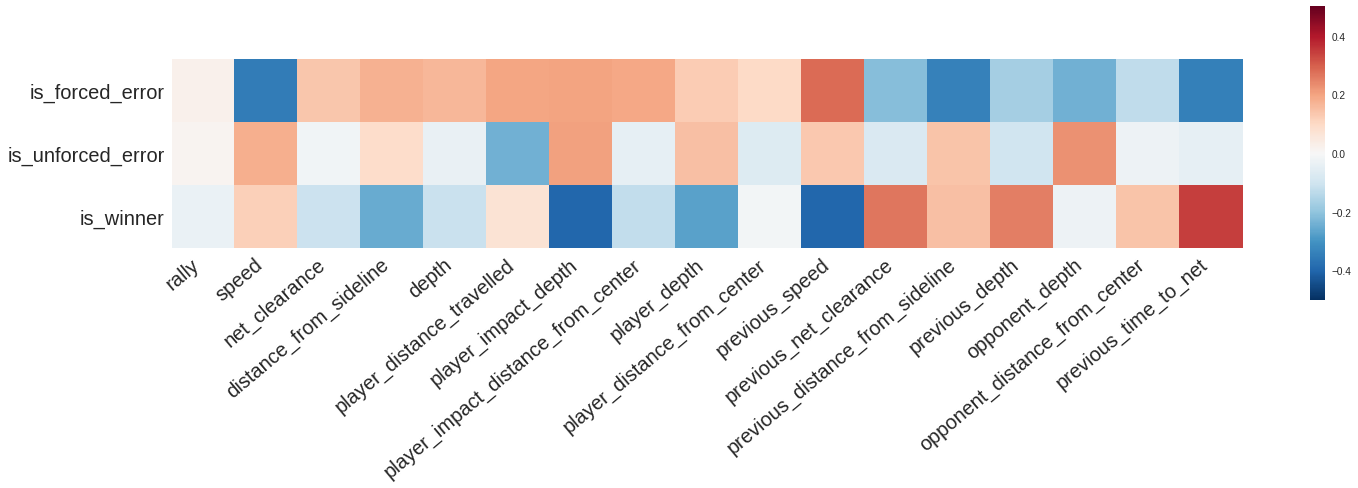

In [4]:
remove_vars = ['serve', 'hitpoint', 'outside_sideline',               
               'outside_baseline', 'same_side', 'previous_hitpoint',
               'server_is_impact_player', 'gender']
response_vars = ['is_forced_error', 'is_unforced_error', 'is_winner']

plot_cols = df_train.drop(remove_vars, axis=1).columns.tolist()

corrmat = df_train[plot_cols].corr()
f, ax = plt.subplots(figsize=(24, 18))
heatmap = sns.heatmap(corrmat.loc[-corrmat.index.isin(response_vars), response_vars].T, 
            vmax=0.5, square=True, center = 0,
            cbar_kws={'shrink': 0.3})
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=40, fontsize=20, ha='right')
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0, fontsize=20)
plt.show()

From this, my initial hypotheses are:

* <u>Winner</u> = long previous time to net, slow previous speed, not returned from deep, hit toward the sideline
* <u>Unforced error</u> = high speed, hit from deep
* <u>Forced error</u> = low speed, previous shot close to sideline, previous shot hit hard

We will return to these hypotheses after a little detour onto the court.

# Build base tennis court plot and display final ball location on the court
We build a basic "tennis court" represenation of the tracking data to better visualize the point outcomes.

This representation reveals some strong points about the domain. While final ball location doesn't distinguish between the types of errors, winners have to end up in bounds as one would expect. It is interesting to note that the tracker may not always be reliable.

In [5]:
oob_width = 16
oob_depth = 15
doubles_width = 10.97
singles_width = 8.23
service_box_depth = 6.4
side_depth = 11.89
center_mark = 0.4

In [6]:
boxes = pd.DataFrame(data={
    'name': ['oob','doubles', 'singles', 'service'],
    'x_min': [-oob_width/2, -doubles_width/2, -singles_width/2, -singles_width/2],
    'x_max': [oob_width/2, doubles_width/2, singles_width/2, singles_width/2],
    'y_min': [-oob_depth, -side_depth, -side_depth, -service_box_depth],
    'y_max': [oob_depth, side_depth, side_depth, service_box_depth]})

net = pd.DataFrame(data={'x':[-doubles_width/2, doubles_width/2], 'y':[0,0]})
service_box = pd.DataFrame(data={'x':[0,0], 'y':[-service_box_depth, service_box_depth]})
cmark0 = pd.DataFrame(data={'x':[0,0], 'y':[-side_depth, -side_depth+center_mark]})
cmark1 = pd.DataFrame(data={'x':[0,0], 'y':[side_depth, side_depth-center_mark]})
    
tennis_court = (p9.ggplot()
 + p9.geom_rect(boxes,
        p9.aes(xmin='x_min', xmax='x_max', ymin='y_min', ymax='y_max'),
        fill='darkgreen', color='white')
 + p9.geom_path(net, p9.aes(x='x', y='y'), color='white')
 + p9.geom_path(service_box, p9.aes(x='x', y='y'), color='white')
 + p9.geom_path(cmark0, p9.aes(x='x', y='y'), color='white')
 + p9.geom_path(cmark1, p9.aes(x='x', y='y'), color='white')
 + p9.coord_fixed()
 + p9.theme_void()
)

In [7]:
df_train['x_loc'] = singles_width / 2 + \
    df_train['distance_from_sideline'] * np.where(df_train['outside_sideline'], 1, -1)
df_train['y_loc'] = np.where(df_train['net_clearance'] > 0, 
    side_depth + df_train['depth'] * np.where(df_train['outside_baseline'], 1, -1),
    -side_depth + df_train['depth'] * np.where(df_train['outside_baseline'], -1, 1))

# Make sure we are plotting within our court
df_train.loc[df_train['x_loc'] > oob_width/2, 'x_loc'] = oob_width/2
df_train.loc[df_train['x_loc'] < -oob_width/2, 'x_loc'] = -oob_width/2
df_train.loc[df_train['y_loc'] > oob_depth, 'y_loc'] = oob_depth
df_train.loc[df_train['y_loc'] < -oob_depth, 'y_loc'] = -oob_depth

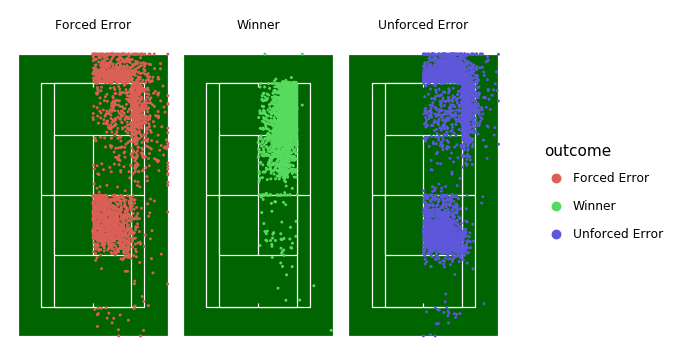

<ggplot: (8766049144668)>

In [8]:
(tennis_court + p9.geom_point(data=df_train, 
    mapping=p9.aes(x='x_loc', y='y_loc', color='outcome'), size=0.2)
    + p9.facet_wrap('~ outcome')
    + p9.guides(color=p9.guide_legend(override_aes={'size': 3})))

# Defining what a winner is

According to our court visualization and intuition, a winner <i>should</i> be defined as a shot that is untouched by your opponent that goes over the net and lands inside the baseline and sidelines. Let's see how much variance there is in the HawkEye sensor data...

In [9]:
# Is the point an expected winner?
## net.clearance (> 0)
## outside_sideline (False)
## outside_baseline (False)  

df_train['clears_net'] = df_train['net_clearance'] > 0
df_train['expected_winner'] = (df_train['clears_net'] & 
                               -df_train['outside_sideline'] & 
                               -df_train['outside_baseline'])

df_train['faulty_expected_winner'] = (df_train['expected_winner'] == True) & (df_train['outcome'] != 'Winner')

In [10]:
df_train_counts = df_train.groupby(['expected_winner', 'outcome'])['rally'].count()

((df_train_counts / df_train_counts.groupby(['expected_winner']) \
    .transform(sum))
 .reset_index()
 .rename(columns={'rally': '% of points'})
 .style.format({'% of points': '{:,.1%}'.format}))

,expected_winner,outcome,% of points
0,False,Forced Error,32.9%
1,False,Winner,1.4%
2,False,Unforced Error,65.7%
3,True,Forced Error,6.0%
4,True,Winner,86.5%
5,True,Unforced Error,7.6%


While only 1.4% of expected errors are called winners (maybe due to unchallenged line calls), <b>a whopping 13.5% of "expected winners" are not actually winners</b>. This is likely due to the ball sensors encountering difficult situations.

So what contributes to the inaccuracies of the sensor data? To me, many of these shots look like "shanks", which may be hard for the sensors to accurately track and record. Many faulty expected winners have very large net clearnace.

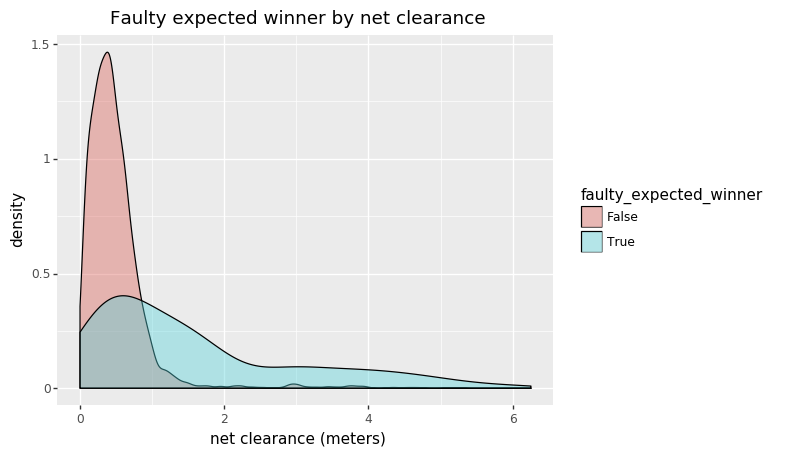

<ggplot: (8766039521656)>

In [11]:
df_expected_winner = df_train[df_train['expected_winner'] == True]

(p9.ggplot(df_expected_winner[df_expected_winner['net_clearance'] < 7], 
           p9.aes(x = 'net_clearance', fill = 'faulty_expected_winner')) +
    p9.geom_density(alpha = 0.4) +
    p9.scale_x_continuous() +
    p9.labs(x = 'net clearance (meters)', y = 'density',
            title = 'Faulty expected winner by net clearance'))

#### _A shank by Cilic that might not be handled properly by the sensors_

![](media/shank.gif)

And, they tend to have a speed distribution that looks less like a winner (harder previous shot).

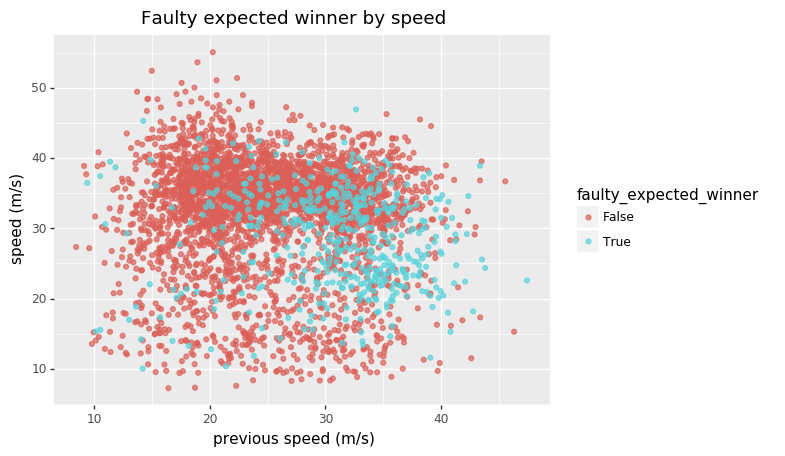

<ggplot: (8766066665259)>

In [12]:
(p9.ggplot(df_expected_winner, p9.aes(x = 'previous_speed', y = 'speed', color = 'faulty_expected_winner')) +
    p9.geom_point(alpha = 0.7) +
    p9.labs(x = 'previous speed (m/s)', y = 'speed (m/s)',
            title = 'Faulty expected winner by speed'))

# Exploring important features
We now revisit the hypotheses from the highly correlated features to see if we can gain any deeper insights.

### Ball speed
The time that it takes the penultimate shot to reach the net is distributed differently for each outcome.

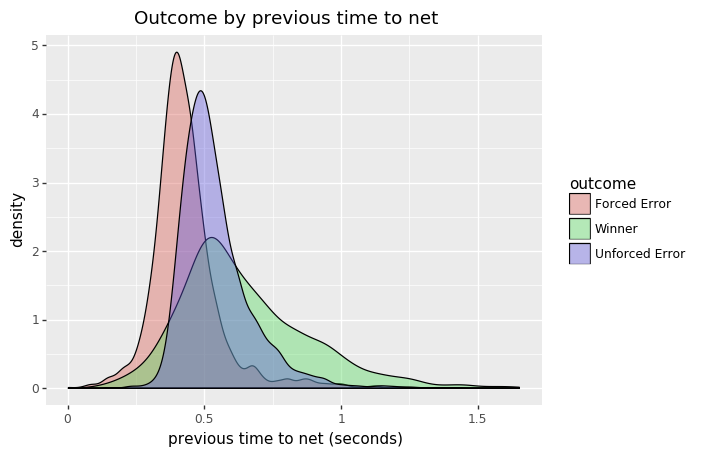

<ggplot: (-9223363270776751570)>

In [13]:
(p9.ggplot(df_train, p9.aes(x = 'previous_time_to_net', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.labs(x = 'previous time to net (seconds)', y = 'density',
            title = 'Outcome by previous time to net'))

The more natural corollary here is the speed with which that shot is hit. It is very clear that winners are hit when the prior shot is not hit all that hard. On the other end of the spectrum, when the previous shot is hit with pace, forced errors are more likely to be commited.

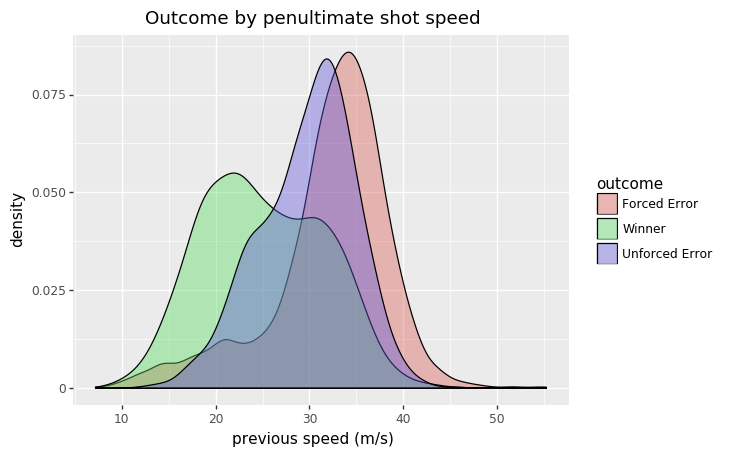

<ggplot: (8766048917901)>

In [14]:
(p9.ggplot(df_train, p9.aes(x = 'previous_speed', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.labs(x = 'previous speed (m/s)', y = 'density',
            title = 'Outcome by penultimate shot speed'))

As expected, the point-ending shot itself exhibits the opposite behavior. Winners are hit harder and forced errors generally don't have much behind them. There are several winners at low speeds that likely represent lob and drops shots, or just passing shots where there isn't any need for pace.

Both the penultimate and ultimate shots that end in an unforced error tend to look very similar in terms of speed. We'd expect that if we had access to <i>all</i> shots, that these unforced errors would also look similar to normal rally shots.

![](media/unforced.gif)

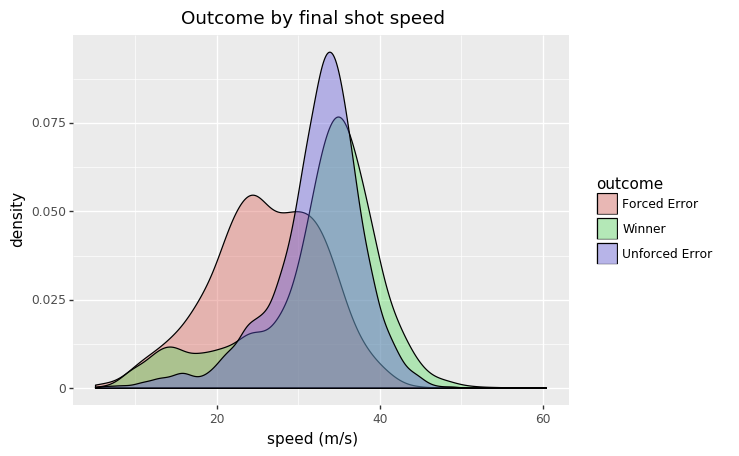

<ggplot: (8766039702753)>

In [15]:
(p9.ggplot(df_train, p9.aes(x = 'speed', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.labs(x = 'speed (m/s)', y = 'density',
            title = 'Outcome by final shot speed'))

#### _Cilic gets a slow penultimate shot and bangs a winner down the line_

![](media/winner.gif)

### Impact depth

The non-normal distribution of player depth on winners is interesting. The heavy tail of players being close to the net likely corresponds to approach shots.

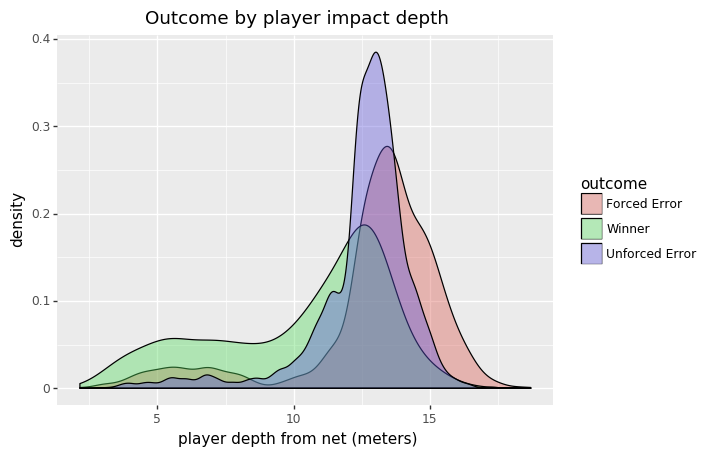

<ggplot: (8766066710960)>

In [16]:
(p9.ggplot(df_train, p9.aes(x = 'player_impact_depth', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.labs(x = 'player depth from net (meters)', y = 'density',
            title = 'Outcome by player impact depth'))

#### _Federer hits an approach shot for a winner_

![](media/approach.gif)

### Horizontal ball placement
The horizontal location of the shot is also informative. Winners are generally hit down the line, while other shots are more widely distributed.

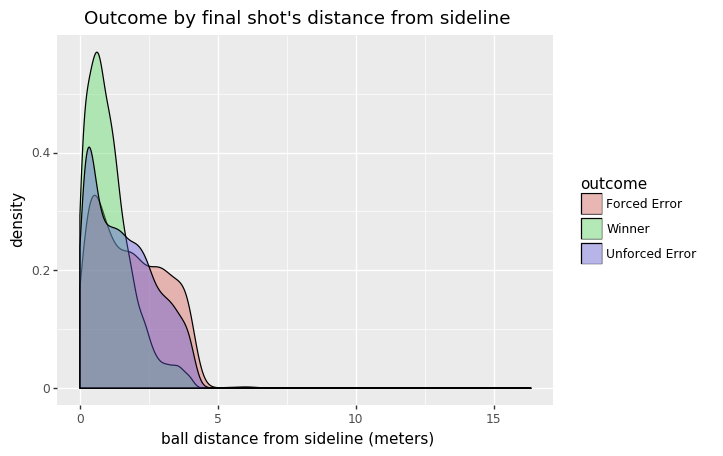

<ggplot: (-9223363270815196742)>

In [17]:
(p9.ggplot(df_train, p9.aes(x = 'distance_from_sideline', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.labs(x = 'ball distance from sideline (meters)', y = 'density',
            title = 'Outcome by final shot\'s distance from sideline'))

When the penultimate shot is hit down the line, a player is forced into an error. This makes sense -- either a good shot down the line is a winner, or it forces your opponent into a difficult return.

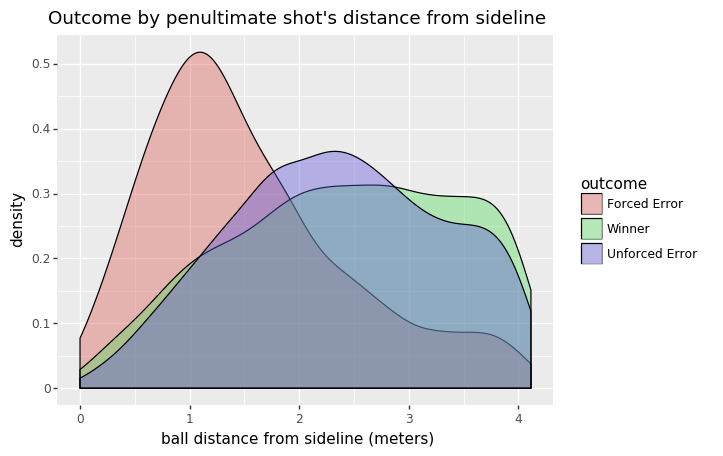

<ggplot: (-9223363270815297848)>

In [18]:
(p9.ggplot(df_train, p9.aes(x = 'previous_distance_from_sideline', fill = 'outcome')) +
    p9.geom_density(alpha = 0.4) +
    p9.labs(x = 'ball distance from sideline (meters)', y = 'density',
            title = 'Outcome by penultimate shot\'s distance from sideline'))

Forced errors come off your racket way slower than other shots. Winners come at the top pace although there may be some lob and drop shots. Unforced errors can be hit just as hard (but they probably go into the net or wide or deep).

#### _Federer is forced into an error by a shot down the line_

![](media/forced.gif)

# Conclusion


...
...